In [100]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# load data
df_resampled = pd.read_pickle("./data_for_modeling.pickle")

In [114]:
df_resampled

,ピッチ (度),Relative wind speed[m/s],相対風速 (m/s)_cos,相対風速 (m/s)_sin,Course[deg],Speed[knot],SPC_flux[mm],mwp,t2m,sst,...,27,28,29,30,Relative_wind_direction[deg],Relative wave direction[deg],Speed[m/s],encounter cycle,wave_length,ratio
datetime,,,,,,,,,,,,,,,,,,,,,
2018-11-30 07:18:21,0.103984,1.10,0.993268,0.115843,220.758026,0.070190,0.0,9.379121,292.978162,292.091290,...,0.003300,0.002143,0.000979,-0.000185,6.652247,95.369988,0.036106,9.381288,137.205182,0.994240
2018-11-30 07:18:22,0.103545,1.10,0.993822,0.096423,220.750641,0.072903,0.0,9.379121,292.978162,292.091290,...,0.019447,0.017960,0.016489,0.015037,5.541645,95.362603,0.037501,9.381369,137.205182,0.994240
2018-11-30 07:18:23,0.103107,1.10,0.994377,0.077004,220.743256,0.075616,0.0,9.379121,292.978162,292.091290,...,0.035473,0.033668,0.031900,0.030169,4.428097,95.355217,0.038897,9.381449,137.205182,0.994240
2018-11-30 07:18:24,0.102668,1.10,0.994932,0.057584,220.735870,0.078328,0.0,9.379121,292.978162,292.091290,...,0.051309,0.049204,0.047155,0.045161,3.312434,95.347832,0.040292,9.381530,137.205182,0.994240
2018-11-30 07:18:25,0.102229,1.10,0.995487,0.038164,220.728485,0.081041,0.0,9.379121,292.978162,292.091290,...,0.066891,0.064510,0.062201,0.059962,2.195500,95.340447,0.041688,9.381610,137.205182,0.994240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-16 22:08:20,0.199681,9.21,-0.926047,-0.316347,4.122388,12.539062,0.0,7.443690,293.509095,293.192482,...,-0.243906,-0.179116,-0.108526,-0.033104,18.860695,346.994162,6.450094,4.829460,86.421685,0.626244
2019-03-16 22:08:21,0.201702,9.30,-0.922965,-0.384884,4.150687,12.539673,0.0,7.443690,293.509095,293.192482,...,-0.285918,-0.225876,-0.159502,-0.087780,22.636540,347.022460,6.450408,4.829184,86.421685,0.626244
2019-03-16 22:08:22,0.190759,9.30,-0.924889,-0.379941,4.186893,12.535265,0.0,7.443690,293.509095,293.192482,...,-0.324857,-0.269653,-0.207618,-0.139745,22.332657,347.058666,6.448140,4.829533,86.421685,0.626244


In [115]:
df_resampled_minute = df_resampled.resample("min").nearest()
df_resampled_hour = df_resampled.resample("H").nearest()

In [116]:
df_resampled_hour['tp'] = df_resampled_hour['tp'] * 3600
df_resampled_minute['tp'] = df_resampled_minute['tp'] * 3600

In [120]:
df_resampled_minute = df_resampled_minute[df_resampled_minute['tp'] < (0.01 / 1000) / 3600]
df_resampled_hour = df_resampled_hour[df_resampled_hour['tp'] < (0.01 / 1000) / 3600]
df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 3600]

In [124]:
df_copy = df_resampled_minute

In [125]:
#df_copy = df_resampled.copy()
# 飛沫データのラベリング
spray_all = np.array(df_copy['SPC_flux[mm]'])
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i > 0.0 else 0 for i in spray_all]
df_copy['label'] = spc_label

/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)

4371 147 3.363074811256005


# 普通にlightgbm

In [129]:
df_copy.columns

Index([                     'ピッチ (度)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
                                'swh',                          'u10',
                                'v10',                        'label',
                    'relative_wind_y',                              1,
                                    2,                              3,
                                    4,                              5,
                                    6,                              7,
                                    8,                              9,
                                   10,                             11,
      

In [135]:
X = df_copy.loc[:, [i for i in df_copy.columns if i != 'SPC_flux[mm]' and i != 'label']]
y = df_copy.loc[:, "label"]

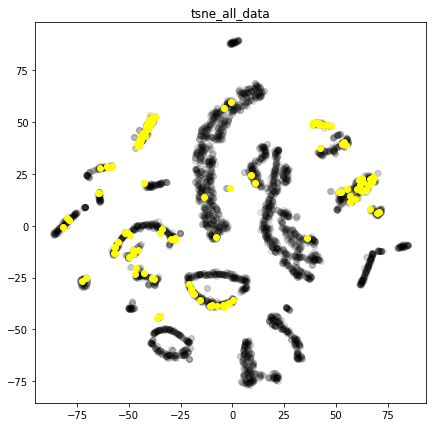

<Figure size 432x288 with 0 Axes>

In [146]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/home/nt/Desktop/soturon'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title(image_name)
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))


plot_reduced_graph(X, y, 'tsne_all_data', model='tsne', random_sampling=False)

In [56]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test
    
def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

print(len(y_train), len(y_test), len(y_train2), len(y_valid))

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
57
755270 188818 604216 151054


In [57]:
lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

[1]	valid_0's binary_logloss: 0.186883
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.183059
[3]	valid_0's binary_logloss: 0.179499
[4]	valid_0's binary_logloss: 0.174671
[5]	valid_0's binary_logloss: 0.172894
[6]	valid_0's binary_logloss: 0.170476
[7]	valid_0's binary_logloss: 0.169214
[8]	valid_0's binary_logloss: 0.167548
[9]	valid_0's binary_logloss: 0.16615
[10]	valid_0's binary_logloss: 0.164764
[11]	valid_0's binary_logloss: 0.163332
[12]	valid_0's binary_logloss: 0.161881
[13]	valid_0's binary_logloss: 0.160801
[14]	valid_0's binary_logloss: 0.159581
[15]	valid_0's binary_logloss: 0.158418
[16]	valid_0's binary_logloss: 0.157769
[17]	valid_0's binary_logloss: 0.156446
[18]	valid_0's binary_logloss: 0.155175
[19]	valid_0's binary_logloss: 0.154476
[20]	valid_0's binary_logloss: 0.153796
[21]	valid_0's binary_logloss: 0.152905
[22]	valid_0's binary_logloss: 0.15214
[23]	valid_0's binary_logloss: 0.151005
[24]	valid_0's binary_logloss:

[206]	valid_0's binary_logloss: 0.124234
[207]	valid_0's binary_logloss: 0.124222
[208]	valid_0's binary_logloss: 0.124211
[209]	valid_0's binary_logloss: 0.12418
[210]	valid_0's binary_logloss: 0.124104
[211]	valid_0's binary_logloss: 0.124085
[212]	valid_0's binary_logloss: 0.124027
[213]	valid_0's binary_logloss: 0.124025
[214]	valid_0's binary_logloss: 0.123986
[215]	valid_0's binary_logloss: 0.123951
[216]	valid_0's binary_logloss: 0.12392
[217]	valid_0's binary_logloss: 0.123901
[218]	valid_0's binary_logloss: 0.123889
[219]	valid_0's binary_logloss: 0.123858
[220]	valid_0's binary_logloss: 0.123806
[221]	valid_0's binary_logloss: 0.123771
[222]	valid_0's binary_logloss: 0.123715
[223]	valid_0's binary_logloss: 0.123666
[224]	valid_0's binary_logloss: 0.123661
[225]	valid_0's binary_logloss: 0.123633
[226]	valid_0's binary_logloss: 0.123594
[227]	valid_0's binary_logloss: 0.12358
[228]	valid_0's binary_logloss: 0.123519
[229]	valid_0's binary_logloss: 0.12351
[230]	valid_0's bina

[410]	valid_0's binary_logloss: 0.119764
[411]	valid_0's binary_logloss: 0.119757
[412]	valid_0's binary_logloss: 0.119751
[413]	valid_0's binary_logloss: 0.119741
[414]	valid_0's binary_logloss: 0.119736
[415]	valid_0's binary_logloss: 0.119727
[416]	valid_0's binary_logloss: 0.119717
[417]	valid_0's binary_logloss: 0.119711
[418]	valid_0's binary_logloss: 0.119708
[419]	valid_0's binary_logloss: 0.119684
[420]	valid_0's binary_logloss: 0.119686
[421]	valid_0's binary_logloss: 0.119683
[422]	valid_0's binary_logloss: 0.119677
[423]	valid_0's binary_logloss: 0.11967
[424]	valid_0's binary_logloss: 0.119664
[425]	valid_0's binary_logloss: 0.119625
[426]	valid_0's binary_logloss: 0.119609
[427]	valid_0's binary_logloss: 0.119608
[428]	valid_0's binary_logloss: 0.119605
[429]	valid_0's binary_logloss: 0.119602
[430]	valid_0's binary_logloss: 0.119601
[431]	valid_0's binary_logloss: 0.119596
[432]	valid_0's binary_logloss: 0.119581
[433]	valid_0's binary_logloss: 0.119572
[434]	valid_0's b

[611]	valid_0's binary_logloss: 0.117764
[612]	valid_0's binary_logloss: 0.117762
[613]	valid_0's binary_logloss: 0.11776
[614]	valid_0's binary_logloss: 0.117763
[615]	valid_0's binary_logloss: 0.117763
[616]	valid_0's binary_logloss: 0.117755
[617]	valid_0's binary_logloss: 0.117747
[618]	valid_0's binary_logloss: 0.117749
[619]	valid_0's binary_logloss: 0.117734
[620]	valid_0's binary_logloss: 0.117725
[621]	valid_0's binary_logloss: 0.117721
[622]	valid_0's binary_logloss: 0.117719
[623]	valid_0's binary_logloss: 0.117716
[624]	valid_0's binary_logloss: 0.117707
[625]	valid_0's binary_logloss: 0.117698
[626]	valid_0's binary_logloss: 0.11769
[627]	valid_0's binary_logloss: 0.117687
[628]	valid_0's binary_logloss: 0.117684
[629]	valid_0's binary_logloss: 0.117671
[630]	valid_0's binary_logloss: 0.117658
[631]	valid_0's binary_logloss: 0.117652
[632]	valid_0's binary_logloss: 0.117635
[633]	valid_0's binary_logloss: 0.117635
[634]	valid_0's binary_logloss: 0.117634
[635]	valid_0's bi

[812]	valid_0's binary_logloss: 0.116461
[813]	valid_0's binary_logloss: 0.116461
[814]	valid_0's binary_logloss: 0.116451
[815]	valid_0's binary_logloss: 0.11645
[816]	valid_0's binary_logloss: 0.116428
[817]	valid_0's binary_logloss: 0.11643
[818]	valid_0's binary_logloss: 0.116426
[819]	valid_0's binary_logloss: 0.116425
[820]	valid_0's binary_logloss: 0.116423
[821]	valid_0's binary_logloss: 0.116421
[822]	valid_0's binary_logloss: 0.116422
[823]	valid_0's binary_logloss: 0.116412
[824]	valid_0's binary_logloss: 0.116408
[825]	valid_0's binary_logloss: 0.116409
[826]	valid_0's binary_logloss: 0.116401
[827]	valid_0's binary_logloss: 0.116403
[828]	valid_0's binary_logloss: 0.1164
[829]	valid_0's binary_logloss: 0.116392
[830]	valid_0's binary_logloss: 0.116388
[831]	valid_0's binary_logloss: 0.116373
[832]	valid_0's binary_logloss: 0.116365
[833]	valid_0's binary_logloss: 0.116339
[834]	valid_0's binary_logloss: 0.116338
[835]	valid_0's binary_logloss: 0.116336
[836]	valid_0's bina

# KFoldではない

In [98]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
#for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling = ['swh']
#for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model
    
def imbalanced_data_split_(X, y, seed1, seed2, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=5, random_state=seed1)
    cms = []
    f_score = []
    recall = []
    precision = []
    accuracy = []
    for train_index, test_index in tqdm(sss.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(len(X_train), len(X_test))
        
        X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed2, test_size=0.2)
        model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

        y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
        y_pred_binary = []
        for p in y_pred:
            if p >= 0.2:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)

        from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
        cm = confusion_matrix(y_test, y_pred_binary)
        print(cm)
        cms.append(cm)
        accuracy.append(accuracy_score(y_pred_binary, y_test))
        recall.append(recall_score(y_pred_binary, y_test))
        precision.append(precision_score(y_pred_binary, y_test))
        f_score.append(f1_score(y_pred_binary, y_test))
        
    return cms, accuracy, recall, precision, f_score
            
    
date = datetime.now()
seed2 = date.minute + date.second + date.hour

cms, accuracy, recall, precision, f_score = imbalanced_data_split_(X, y, seed1, seed2)




0it [00:00, ?it/s]

['swh']
64
849679 94409
[1]	valid_0's binary_logloss: 0.18807
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.183782
[3]	valid_0's binary_logloss: 0.181189
[4]	valid_0's binary_logloss: 0.178556
[5]	valid_0's binary_logloss: 0.176239
[6]	valid_0's binary_logloss: 0.174654
[7]	valid_0's binary_logloss: 0.173456
[8]	valid_0's binary_logloss: 0.17219
[9]	valid_0's binary_logloss: 0.16993
[10]	valid_0's binary_logloss: 0.169062
[11]	valid_0's binary_logloss: 0.167388
[12]	valid_0's binary_logloss: 0.166766
[13]	valid_0's binary_logloss: 0.165714
[14]	valid_0's binary_logloss: 0.165129
[15]	valid_0's binary_logloss: 0.164244
[16]	valid_0's binary_logloss: 0.163797
[17]	valid_0's binary_logloss: 0.163246
[18]	valid_0's binary_logloss: 0.16255
[19]	valid_0's binary_logloss: 0.161608
[20]	valid_0's binary_logloss: 0.161114
[21]	valid_0's binary_logloss: 0.160676
[22]	valid_0's binary_logloss: 0.160233
[23]	valid_0's binary_logloss: 0.15982
[24]	vali

[205]	valid_0's binary_logloss: 0.135618
[206]	valid_0's binary_logloss: 0.13558
[207]	valid_0's binary_logloss: 0.135534
[208]	valid_0's binary_logloss: 0.135482
[209]	valid_0's binary_logloss: 0.135458
[210]	valid_0's binary_logloss: 0.135438
[211]	valid_0's binary_logloss: 0.135407
[212]	valid_0's binary_logloss: 0.13538
[213]	valid_0's binary_logloss: 0.135342
[214]	valid_0's binary_logloss: 0.135309
[215]	valid_0's binary_logloss: 0.135268
[216]	valid_0's binary_logloss: 0.135237
[217]	valid_0's binary_logloss: 0.135231
[218]	valid_0's binary_logloss: 0.135203
[219]	valid_0's binary_logloss: 0.135194
[220]	valid_0's binary_logloss: 0.135149
[221]	valid_0's binary_logloss: 0.135118
[222]	valid_0's binary_logloss: 0.135084
[223]	valid_0's binary_logloss: 0.135072
[224]	valid_0's binary_logloss: 0.13503
[225]	valid_0's binary_logloss: 0.134979
[226]	valid_0's binary_logloss: 0.134933
[227]	valid_0's binary_logloss: 0.134897
[228]	valid_0's binary_logloss: 0.134834
[229]	valid_0's bin

[412]	valid_0's binary_logloss: 0.131511
[413]	valid_0's binary_logloss: 0.131507
[414]	valid_0's binary_logloss: 0.131496
[415]	valid_0's binary_logloss: 0.13148
[416]	valid_0's binary_logloss: 0.131478
[417]	valid_0's binary_logloss: 0.131469
[418]	valid_0's binary_logloss: 0.131466
[419]	valid_0's binary_logloss: 0.131456
[420]	valid_0's binary_logloss: 0.13144
[421]	valid_0's binary_logloss: 0.131426
[422]	valid_0's binary_logloss: 0.131417
[423]	valid_0's binary_logloss: 0.131413
[424]	valid_0's binary_logloss: 0.131412
[425]	valid_0's binary_logloss: 0.131397
[426]	valid_0's binary_logloss: 0.131385
[427]	valid_0's binary_logloss: 0.131377
[428]	valid_0's binary_logloss: 0.131359
[429]	valid_0's binary_logloss: 0.131353
[430]	valid_0's binary_logloss: 0.131339
[431]	valid_0's binary_logloss: 0.131335
[432]	valid_0's binary_logloss: 0.13133
[433]	valid_0's binary_logloss: 0.131321
[434]	valid_0's binary_logloss: 0.13131
[435]	valid_0's binary_logloss: 0.131299
[436]	valid_0's bina

[619]	valid_0's binary_logloss: 0.130182
[620]	valid_0's binary_logloss: 0.130175
[621]	valid_0's binary_logloss: 0.130171
[622]	valid_0's binary_logloss: 0.130167
[623]	valid_0's binary_logloss: 0.130162
[624]	valid_0's binary_logloss: 0.130158
[625]	valid_0's binary_logloss: 0.130155
[626]	valid_0's binary_logloss: 0.130154
[627]	valid_0's binary_logloss: 0.130146
[628]	valid_0's binary_logloss: 0.130143
[629]	valid_0's binary_logloss: 0.130137
[630]	valid_0's binary_logloss: 0.130131
[631]	valid_0's binary_logloss: 0.130125
[632]	valid_0's binary_logloss: 0.130119
[633]	valid_0's binary_logloss: 0.130117
[634]	valid_0's binary_logloss: 0.13011
[635]	valid_0's binary_logloss: 0.13011
[636]	valid_0's binary_logloss: 0.130107
[637]	valid_0's binary_logloss: 0.130103
[638]	valid_0's binary_logloss: 0.130101
[639]	valid_0's binary_logloss: 0.130097
[640]	valid_0's binary_logloss: 0.130092
[641]	valid_0's binary_logloss: 0.13009
[642]	valid_0's binary_logloss: 0.13009
[643]	valid_0's bina

[827]	valid_0's binary_logloss: 0.129649
[828]	valid_0's binary_logloss: 0.129647
[829]	valid_0's binary_logloss: 0.129646
[830]	valid_0's binary_logloss: 0.129645
[831]	valid_0's binary_logloss: 0.129644
[832]	valid_0's binary_logloss: 0.129643
[833]	valid_0's binary_logloss: 0.129642
[834]	valid_0's binary_logloss: 0.129642
[835]	valid_0's binary_logloss: 0.12964
[836]	valid_0's binary_logloss: 0.129639
[837]	valid_0's binary_logloss: 0.129638
[838]	valid_0's binary_logloss: 0.129637
[839]	valid_0's binary_logloss: 0.129636
[840]	valid_0's binary_logloss: 0.129634
[841]	valid_0's binary_logloss: 0.129634
[842]	valid_0's binary_logloss: 0.129632
[843]	valid_0's binary_logloss: 0.129629
[844]	valid_0's binary_logloss: 0.129628
[845]	valid_0's binary_logloss: 0.129627
[846]	valid_0's binary_logloss: 0.129626
[847]	valid_0's binary_logloss: 0.129626
[848]	valid_0's binary_logloss: 0.129624
[849]	valid_0's binary_logloss: 0.129623
[850]	valid_0's binary_logloss: 0.129623
[851]	valid_0's b




1it [00:33, 33.25s/it]

[[85432  4328]
 [ 2067  2582]]
849679 94409
[1]	valid_0's binary_logloss: 0.187701
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.18206
[3]	valid_0's binary_logloss: 0.178906
[4]	valid_0's binary_logloss: 0.177036
[5]	valid_0's binary_logloss: 0.175345
[6]	valid_0's binary_logloss: 0.173872
[7]	valid_0's binary_logloss: 0.17259
[8]	valid_0's binary_logloss: 0.170963
[9]	valid_0's binary_logloss: 0.169871
[10]	valid_0's binary_logloss: 0.168662
[11]	valid_0's binary_logloss: 0.16778
[12]	valid_0's binary_logloss: 0.165861
[13]	valid_0's binary_logloss: 0.165264
[14]	valid_0's binary_logloss: 0.164583
[15]	valid_0's binary_logloss: 0.163648
[16]	valid_0's binary_logloss: 0.163147
[17]	valid_0's binary_logloss: 0.162212
[18]	valid_0's binary_logloss: 0.161503
[19]	valid_0's binary_logloss: 0.160685
[20]	valid_0's binary_logloss: 0.160151
[21]	valid_0's binary_logloss: 0.159647
[22]	valid_0's binary_logloss: 0.159243
[23]	valid_0's binary_loglo

[205]	valid_0's binary_logloss: 0.134621
[206]	valid_0's binary_logloss: 0.134583
[207]	valid_0's binary_logloss: 0.134525
[208]	valid_0's binary_logloss: 0.134496
[209]	valid_0's binary_logloss: 0.134431
[210]	valid_0's binary_logloss: 0.134392
[211]	valid_0's binary_logloss: 0.134353
[212]	valid_0's binary_logloss: 0.134306
[213]	valid_0's binary_logloss: 0.134267
[214]	valid_0's binary_logloss: 0.134234
[215]	valid_0's binary_logloss: 0.134227
[216]	valid_0's binary_logloss: 0.134197
[217]	valid_0's binary_logloss: 0.134182
[218]	valid_0's binary_logloss: 0.134157
[219]	valid_0's binary_logloss: 0.134141
[220]	valid_0's binary_logloss: 0.134111
[221]	valid_0's binary_logloss: 0.134057
[222]	valid_0's binary_logloss: 0.133985
[223]	valid_0's binary_logloss: 0.133953
[224]	valid_0's binary_logloss: 0.133899
[225]	valid_0's binary_logloss: 0.133861
[226]	valid_0's binary_logloss: 0.13383
[227]	valid_0's binary_logloss: 0.133824
[228]	valid_0's binary_logloss: 0.133817
[229]	valid_0's b

[410]	valid_0's binary_logloss: 0.130565
[411]	valid_0's binary_logloss: 0.130563
[412]	valid_0's binary_logloss: 0.130555
[413]	valid_0's binary_logloss: 0.130539
[414]	valid_0's binary_logloss: 0.130537
[415]	valid_0's binary_logloss: 0.130526
[416]	valid_0's binary_logloss: 0.130522
[417]	valid_0's binary_logloss: 0.130507
[418]	valid_0's binary_logloss: 0.130498
[419]	valid_0's binary_logloss: 0.130493
[420]	valid_0's binary_logloss: 0.13048
[421]	valid_0's binary_logloss: 0.130472
[422]	valid_0's binary_logloss: 0.130461
[423]	valid_0's binary_logloss: 0.130456
[424]	valid_0's binary_logloss: 0.130443
[425]	valid_0's binary_logloss: 0.130437
[426]	valid_0's binary_logloss: 0.130429
[427]	valid_0's binary_logloss: 0.130415
[428]	valid_0's binary_logloss: 0.130403
[429]	valid_0's binary_logloss: 0.130402
[430]	valid_0's binary_logloss: 0.130392
[431]	valid_0's binary_logloss: 0.130386
[432]	valid_0's binary_logloss: 0.130375
[433]	valid_0's binary_logloss: 0.130369
[434]	valid_0's b

[614]	valid_0's binary_logloss: 0.129475
[615]	valid_0's binary_logloss: 0.129474
[616]	valid_0's binary_logloss: 0.129469
[617]	valid_0's binary_logloss: 0.129466
[618]	valid_0's binary_logloss: 0.129461
[619]	valid_0's binary_logloss: 0.129459
[620]	valid_0's binary_logloss: 0.129457
[621]	valid_0's binary_logloss: 0.129454
[622]	valid_0's binary_logloss: 0.129455
[623]	valid_0's binary_logloss: 0.129455
[624]	valid_0's binary_logloss: 0.12945
[625]	valid_0's binary_logloss: 0.129445
[626]	valid_0's binary_logloss: 0.129442
[627]	valid_0's binary_logloss: 0.129438
[628]	valid_0's binary_logloss: 0.129434
[629]	valid_0's binary_logloss: 0.129433
[630]	valid_0's binary_logloss: 0.129429
[631]	valid_0's binary_logloss: 0.129425
[632]	valid_0's binary_logloss: 0.129421
[633]	valid_0's binary_logloss: 0.129418
[634]	valid_0's binary_logloss: 0.129412
[635]	valid_0's binary_logloss: 0.129409
[636]	valid_0's binary_logloss: 0.129405
[637]	valid_0's binary_logloss: 0.129401
[638]	valid_0's b

[821]	valid_0's binary_logloss: 0.129037
[822]	valid_0's binary_logloss: 0.129036
[823]	valid_0's binary_logloss: 0.129035
[824]	valid_0's binary_logloss: 0.129034
[825]	valid_0's binary_logloss: 0.129033
[826]	valid_0's binary_logloss: 0.129031
[827]	valid_0's binary_logloss: 0.129031
[828]	valid_0's binary_logloss: 0.12903
[829]	valid_0's binary_logloss: 0.129029
[830]	valid_0's binary_logloss: 0.129028
[831]	valid_0's binary_logloss: 0.129027
[832]	valid_0's binary_logloss: 0.129026
[833]	valid_0's binary_logloss: 0.129025
[834]	valid_0's binary_logloss: 0.129024
[835]	valid_0's binary_logloss: 0.129023
[836]	valid_0's binary_logloss: 0.129022
[837]	valid_0's binary_logloss: 0.129022
[838]	valid_0's binary_logloss: 0.129021
[839]	valid_0's binary_logloss: 0.12902
[840]	valid_0's binary_logloss: 0.12902
[841]	valid_0's binary_logloss: 0.12902
[842]	valid_0's binary_logloss: 0.129019
[843]	valid_0's binary_logloss: 0.129019
[844]	valid_0's binary_logloss: 0.129019
[845]	valid_0's bina




2it [01:06, 33.26s/it]

[[85432  4328]
 [ 2139  2510]]
849679 94409
[1]	valid_0's binary_logloss: 0.187909
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.182166
[3]	valid_0's binary_logloss: 0.17902
[4]	valid_0's binary_logloss: 0.177079
[5]	valid_0's binary_logloss: 0.175465
[6]	valid_0's binary_logloss: 0.174153
[7]	valid_0's binary_logloss: 0.17294
[8]	valid_0's binary_logloss: 0.171525
[9]	valid_0's binary_logloss: 0.17054
[10]	valid_0's binary_logloss: 0.169648
[11]	valid_0's binary_logloss: 0.168781
[12]	valid_0's binary_logloss: 0.167921
[13]	valid_0's binary_logloss: 0.167126
[14]	valid_0's binary_logloss: 0.166278
[15]	valid_0's binary_logloss: 0.165622
[16]	valid_0's binary_logloss: 0.164673
[17]	valid_0's binary_logloss: 0.163806
[18]	valid_0's binary_logloss: 0.163329
[19]	valid_0's binary_logloss: 0.162967
[20]	valid_0's binary_logloss: 0.161251
[21]	valid_0's binary_logloss: 0.160786
[22]	valid_0's binary_logloss: 0.16021
[23]	valid_0's binary_loglos

[204]	valid_0's binary_logloss: 0.135283
[205]	valid_0's binary_logloss: 0.135271
[206]	valid_0's binary_logloss: 0.135264
[207]	valid_0's binary_logloss: 0.135243
[208]	valid_0's binary_logloss: 0.135203
[209]	valid_0's binary_logloss: 0.135162
[210]	valid_0's binary_logloss: 0.135107
[211]	valid_0's binary_logloss: 0.135071
[212]	valid_0's binary_logloss: 0.135024
[213]	valid_0's binary_logloss: 0.134971
[214]	valid_0's binary_logloss: 0.134911
[215]	valid_0's binary_logloss: 0.134856
[216]	valid_0's binary_logloss: 0.134814
[217]	valid_0's binary_logloss: 0.134807
[218]	valid_0's binary_logloss: 0.134786
[219]	valid_0's binary_logloss: 0.134746
[220]	valid_0's binary_logloss: 0.134736
[221]	valid_0's binary_logloss: 0.134699
[222]	valid_0's binary_logloss: 0.134659
[223]	valid_0's binary_logloss: 0.134624
[224]	valid_0's binary_logloss: 0.134591
[225]	valid_0's binary_logloss: 0.134582
[226]	valid_0's binary_logloss: 0.134539
[227]	valid_0's binary_logloss: 0.134481
[228]	valid_0's 

[410]	valid_0's binary_logloss: 0.131201
[411]	valid_0's binary_logloss: 0.131183
[412]	valid_0's binary_logloss: 0.13116
[413]	valid_0's binary_logloss: 0.13115
[414]	valid_0's binary_logloss: 0.131143
[415]	valid_0's binary_logloss: 0.131139
[416]	valid_0's binary_logloss: 0.131122
[417]	valid_0's binary_logloss: 0.131115
[418]	valid_0's binary_logloss: 0.131102
[419]	valid_0's binary_logloss: 0.131101
[420]	valid_0's binary_logloss: 0.131099
[421]	valid_0's binary_logloss: 0.131093
[422]	valid_0's binary_logloss: 0.131083
[423]	valid_0's binary_logloss: 0.131072
[424]	valid_0's binary_logloss: 0.13106
[425]	valid_0's binary_logloss: 0.131045
[426]	valid_0's binary_logloss: 0.131035
[427]	valid_0's binary_logloss: 0.131029
[428]	valid_0's binary_logloss: 0.13102
[429]	valid_0's binary_logloss: 0.13101
[430]	valid_0's binary_logloss: 0.131001
[431]	valid_0's binary_logloss: 0.130986
[432]	valid_0's binary_logloss: 0.130981
[433]	valid_0's binary_logloss: 0.13097
[434]	valid_0's binary

[617]	valid_0's binary_logloss: 0.12991
[618]	valid_0's binary_logloss: 0.129904
[619]	valid_0's binary_logloss: 0.129902
[620]	valid_0's binary_logloss: 0.1299
[621]	valid_0's binary_logloss: 0.129896
[622]	valid_0's binary_logloss: 0.12989
[623]	valid_0's binary_logloss: 0.12989
[624]	valid_0's binary_logloss: 0.129882
[625]	valid_0's binary_logloss: 0.129879
[626]	valid_0's binary_logloss: 0.129875
[627]	valid_0's binary_logloss: 0.129874
[628]	valid_0's binary_logloss: 0.129873
[629]	valid_0's binary_logloss: 0.129873
[630]	valid_0's binary_logloss: 0.129868
[631]	valid_0's binary_logloss: 0.129864
[632]	valid_0's binary_logloss: 0.129859
[633]	valid_0's binary_logloss: 0.129855
[634]	valid_0's binary_logloss: 0.12985
[635]	valid_0's binary_logloss: 0.129846
[636]	valid_0's binary_logloss: 0.129845
[637]	valid_0's binary_logloss: 0.129839
[638]	valid_0's binary_logloss: 0.129834
[639]	valid_0's binary_logloss: 0.129829
[640]	valid_0's binary_logloss: 0.129826
[641]	valid_0's binary

[822]	valid_0's binary_logloss: 0.129416
[823]	valid_0's binary_logloss: 0.129415
[824]	valid_0's binary_logloss: 0.129413
[825]	valid_0's binary_logloss: 0.129411
[826]	valid_0's binary_logloss: 0.12941
[827]	valid_0's binary_logloss: 0.129408
[828]	valid_0's binary_logloss: 0.129407
[829]	valid_0's binary_logloss: 0.129406
[830]	valid_0's binary_logloss: 0.129406
[831]	valid_0's binary_logloss: 0.129406
[832]	valid_0's binary_logloss: 0.129403
[833]	valid_0's binary_logloss: 0.129402
[834]	valid_0's binary_logloss: 0.129401
[835]	valid_0's binary_logloss: 0.129399
[836]	valid_0's binary_logloss: 0.129397
[837]	valid_0's binary_logloss: 0.129395
[838]	valid_0's binary_logloss: 0.129392
[839]	valid_0's binary_logloss: 0.129389
[840]	valid_0's binary_logloss: 0.129386
[841]	valid_0's binary_logloss: 0.129385
[842]	valid_0's binary_logloss: 0.129384
[843]	valid_0's binary_logloss: 0.129383
[844]	valid_0's binary_logloss: 0.129382
[845]	valid_0's binary_logloss: 0.12938
[846]	valid_0's bi




3it [01:39, 33.13s/it]

[[85515  4245]
 [ 2257  2392]]
849679 94409
[1]	valid_0's binary_logloss: 0.188067
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.184814
[3]	valid_0's binary_logloss: 0.179801
[4]	valid_0's binary_logloss: 0.177319
[5]	valid_0's binary_logloss: 0.175654
[6]	valid_0's binary_logloss: 0.173239
[7]	valid_0's binary_logloss: 0.172078
[8]	valid_0's binary_logloss: 0.170182
[9]	valid_0's binary_logloss: 0.169098
[10]	valid_0's binary_logloss: 0.168302
[11]	valid_0's binary_logloss: 0.167141
[12]	valid_0's binary_logloss: 0.166429
[13]	valid_0's binary_logloss: 0.165885
[14]	valid_0's binary_logloss: 0.165071
[15]	valid_0's binary_logloss: 0.163762
[16]	valid_0's binary_logloss: 0.163037
[17]	valid_0's binary_logloss: 0.162481
[18]	valid_0's binary_logloss: 0.162097
[19]	valid_0's binary_logloss: 0.161535
[20]	valid_0's binary_logloss: 0.160969
[21]	valid_0's binary_logloss: 0.160643
[22]	valid_0's binary_logloss: 0.160167
[23]	valid_0's binary_lo

[208]	valid_0's binary_logloss: 0.134945
[209]	valid_0's binary_logloss: 0.134913
[210]	valid_0's binary_logloss: 0.134884
[211]	valid_0's binary_logloss: 0.134877
[212]	valid_0's binary_logloss: 0.134843
[213]	valid_0's binary_logloss: 0.134827
[214]	valid_0's binary_logloss: 0.13481
[215]	valid_0's binary_logloss: 0.13479
[216]	valid_0's binary_logloss: 0.134778
[217]	valid_0's binary_logloss: 0.134731
[218]	valid_0's binary_logloss: 0.134689
[219]	valid_0's binary_logloss: 0.134664
[220]	valid_0's binary_logloss: 0.134659
[221]	valid_0's binary_logloss: 0.134581
[222]	valid_0's binary_logloss: 0.134548
[223]	valid_0's binary_logloss: 0.13454
[224]	valid_0's binary_logloss: 0.134511
[225]	valid_0's binary_logloss: 0.134446
[226]	valid_0's binary_logloss: 0.134389
[227]	valid_0's binary_logloss: 0.134383
[228]	valid_0's binary_logloss: 0.134358
[229]	valid_0's binary_logloss: 0.134303
[230]	valid_0's binary_logloss: 0.134277
[231]	valid_0's binary_logloss: 0.134234
[232]	valid_0's bin

[414]	valid_0's binary_logloss: 0.131004
[415]	valid_0's binary_logloss: 0.130991
[416]	valid_0's binary_logloss: 0.130983
[417]	valid_0's binary_logloss: 0.130974
[418]	valid_0's binary_logloss: 0.130971
[419]	valid_0's binary_logloss: 0.130968
[420]	valid_0's binary_logloss: 0.13096
[421]	valid_0's binary_logloss: 0.130956
[422]	valid_0's binary_logloss: 0.130932
[423]	valid_0's binary_logloss: 0.130923
[424]	valid_0's binary_logloss: 0.130911
[425]	valid_0's binary_logloss: 0.130901
[426]	valid_0's binary_logloss: 0.130894
[427]	valid_0's binary_logloss: 0.130886
[428]	valid_0's binary_logloss: 0.130877
[429]	valid_0's binary_logloss: 0.130872
[430]	valid_0's binary_logloss: 0.130866
[431]	valid_0's binary_logloss: 0.130855
[432]	valid_0's binary_logloss: 0.13085
[433]	valid_0's binary_logloss: 0.130836
[434]	valid_0's binary_logloss: 0.130818
[435]	valid_0's binary_logloss: 0.130816
[436]	valid_0's binary_logloss: 0.130805
[437]	valid_0's binary_logloss: 0.130793
[438]	valid_0's bi

[620]	valid_0's binary_logloss: 0.129723
[621]	valid_0's binary_logloss: 0.129719
[622]	valid_0's binary_logloss: 0.129717
[623]	valid_0's binary_logloss: 0.129717
[624]	valid_0's binary_logloss: 0.129713
[625]	valid_0's binary_logloss: 0.129713
[626]	valid_0's binary_logloss: 0.129707
[627]	valid_0's binary_logloss: 0.129705
[628]	valid_0's binary_logloss: 0.129704
[629]	valid_0's binary_logloss: 0.129702
[630]	valid_0's binary_logloss: 0.129701
[631]	valid_0's binary_logloss: 0.129702
[632]	valid_0's binary_logloss: 0.129701
[633]	valid_0's binary_logloss: 0.129695
[634]	valid_0's binary_logloss: 0.129692
[635]	valid_0's binary_logloss: 0.129688
[636]	valid_0's binary_logloss: 0.129684
[637]	valid_0's binary_logloss: 0.129682
[638]	valid_0's binary_logloss: 0.129675
[639]	valid_0's binary_logloss: 0.129666
[640]	valid_0's binary_logloss: 0.129661
[641]	valid_0's binary_logloss: 0.129659
[642]	valid_0's binary_logloss: 0.129655
[643]	valid_0's binary_logloss: 0.129653
[644]	valid_0's 

[824]	valid_0's binary_logloss: 0.129301
[825]	valid_0's binary_logloss: 0.129299
[826]	valid_0's binary_logloss: 0.129298
[827]	valid_0's binary_logloss: 0.129296
[828]	valid_0's binary_logloss: 0.129295
[829]	valid_0's binary_logloss: 0.129294
[830]	valid_0's binary_logloss: 0.129294
[831]	valid_0's binary_logloss: 0.129292
[832]	valid_0's binary_logloss: 0.129291
[833]	valid_0's binary_logloss: 0.129291
[834]	valid_0's binary_logloss: 0.129289
[835]	valid_0's binary_logloss: 0.129286
[836]	valid_0's binary_logloss: 0.129283
[837]	valid_0's binary_logloss: 0.129281
[838]	valid_0's binary_logloss: 0.12928
[839]	valid_0's binary_logloss: 0.129277
[840]	valid_0's binary_logloss: 0.129276
[841]	valid_0's binary_logloss: 0.129275
[842]	valid_0's binary_logloss: 0.129273
[843]	valid_0's binary_logloss: 0.129272
[844]	valid_0's binary_logloss: 0.129271
[845]	valid_0's binary_logloss: 0.129268
[846]	valid_0's binary_logloss: 0.129267
[847]	valid_0's binary_logloss: 0.129266
[848]	valid_0's b




4it [02:12, 33.08s/it]

[[85094  4666]
 [ 2044  2605]]
849679 94409
[1]	valid_0's binary_logloss: 0.189465
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.183898
[3]	valid_0's binary_logloss: 0.180877
[4]	valid_0's binary_logloss: 0.179032
[5]	valid_0's binary_logloss: 0.176987
[6]	valid_0's binary_logloss: 0.175338
[7]	valid_0's binary_logloss: 0.17402
[8]	valid_0's binary_logloss: 0.172844
[9]	valid_0's binary_logloss: 0.171467
[10]	valid_0's binary_logloss: 0.170743
[11]	valid_0's binary_logloss: 0.169663
[12]	valid_0's binary_logloss: 0.167776
[13]	valid_0's binary_logloss: 0.167161
[14]	valid_0's binary_logloss: 0.166005
[15]	valid_0's binary_logloss: 0.165509
[16]	valid_0's binary_logloss: 0.164568
[17]	valid_0's binary_logloss: 0.163775
[18]	valid_0's binary_logloss: 0.163244
[19]	valid_0's binary_logloss: 0.162335
[20]	valid_0's binary_logloss: 0.161441
[21]	valid_0's binary_logloss: 0.160993
[22]	valid_0's binary_logloss: 0.16049
[23]	valid_0's binary_logl

[209]	valid_0's binary_logloss: 0.135602
[210]	valid_0's binary_logloss: 0.135572
[211]	valid_0's binary_logloss: 0.135492
[212]	valid_0's binary_logloss: 0.135448
[213]	valid_0's binary_logloss: 0.135403
[214]	valid_0's binary_logloss: 0.135368
[215]	valid_0's binary_logloss: 0.135303
[216]	valid_0's binary_logloss: 0.135253
[217]	valid_0's binary_logloss: 0.135219
[218]	valid_0's binary_logloss: 0.135194
[219]	valid_0's binary_logloss: 0.135139
[220]	valid_0's binary_logloss: 0.135124
[221]	valid_0's binary_logloss: 0.135104
[222]	valid_0's binary_logloss: 0.135092
[223]	valid_0's binary_logloss: 0.135085
[224]	valid_0's binary_logloss: 0.135047
[225]	valid_0's binary_logloss: 0.13501
[226]	valid_0's binary_logloss: 0.134999
[227]	valid_0's binary_logloss: 0.134991
[228]	valid_0's binary_logloss: 0.134963
[229]	valid_0's binary_logloss: 0.134928
[230]	valid_0's binary_logloss: 0.134881
[231]	valid_0's binary_logloss: 0.134876
[232]	valid_0's binary_logloss: 0.134859
[233]	valid_0's b

[411]	valid_0's binary_logloss: 0.131688
[412]	valid_0's binary_logloss: 0.131681
[413]	valid_0's binary_logloss: 0.131677
[414]	valid_0's binary_logloss: 0.131659
[415]	valid_0's binary_logloss: 0.131651
[416]	valid_0's binary_logloss: 0.131637
[417]	valid_0's binary_logloss: 0.131626
[418]	valid_0's binary_logloss: 0.131617
[419]	valid_0's binary_logloss: 0.131611
[420]	valid_0's binary_logloss: 0.131592
[421]	valid_0's binary_logloss: 0.131576
[422]	valid_0's binary_logloss: 0.131569
[423]	valid_0's binary_logloss: 0.131557
[424]	valid_0's binary_logloss: 0.131548
[425]	valid_0's binary_logloss: 0.131544
[426]	valid_0's binary_logloss: 0.131541
[427]	valid_0's binary_logloss: 0.131529
[428]	valid_0's binary_logloss: 0.13152
[429]	valid_0's binary_logloss: 0.13151
[430]	valid_0's binary_logloss: 0.131506
[431]	valid_0's binary_logloss: 0.13149
[432]	valid_0's binary_logloss: 0.131483
[433]	valid_0's binary_logloss: 0.131482
[434]	valid_0's binary_logloss: 0.131475
[435]	valid_0's bin

[614]	valid_0's binary_logloss: 0.130462
[615]	valid_0's binary_logloss: 0.13045
[616]	valid_0's binary_logloss: 0.13044
[617]	valid_0's binary_logloss: 0.130435
[618]	valid_0's binary_logloss: 0.13043
[619]	valid_0's binary_logloss: 0.130426
[620]	valid_0's binary_logloss: 0.130423
[621]	valid_0's binary_logloss: 0.130419
[622]	valid_0's binary_logloss: 0.130418
[623]	valid_0's binary_logloss: 0.130416
[624]	valid_0's binary_logloss: 0.130413
[625]	valid_0's binary_logloss: 0.130413
[626]	valid_0's binary_logloss: 0.130413
[627]	valid_0's binary_logloss: 0.130409
[628]	valid_0's binary_logloss: 0.130408
[629]	valid_0's binary_logloss: 0.130401
[630]	valid_0's binary_logloss: 0.130398
[631]	valid_0's binary_logloss: 0.130397
[632]	valid_0's binary_logloss: 0.130394
[633]	valid_0's binary_logloss: 0.130387
[634]	valid_0's binary_logloss: 0.130381
[635]	valid_0's binary_logloss: 0.13038
[636]	valid_0's binary_logloss: 0.130376
[637]	valid_0's binary_logloss: 0.130374
[638]	valid_0's bina

[821]	valid_0's binary_logloss: 0.12995
[822]	valid_0's binary_logloss: 0.129949
[823]	valid_0's binary_logloss: 0.129947
[824]	valid_0's binary_logloss: 0.129945
[825]	valid_0's binary_logloss: 0.129945
[826]	valid_0's binary_logloss: 0.129944
[827]	valid_0's binary_logloss: 0.129943
[828]	valid_0's binary_logloss: 0.129943
[829]	valid_0's binary_logloss: 0.129942
[830]	valid_0's binary_logloss: 0.12994
[831]	valid_0's binary_logloss: 0.129941
[832]	valid_0's binary_logloss: 0.12994
[833]	valid_0's binary_logloss: 0.12994
[834]	valid_0's binary_logloss: 0.129937
[835]	valid_0's binary_logloss: 0.129937
[836]	valid_0's binary_logloss: 0.129935
[837]	valid_0's binary_logloss: 0.129935
[838]	valid_0's binary_logloss: 0.129933
[839]	valid_0's binary_logloss: 0.129932
[840]	valid_0's binary_logloss: 0.12993
[841]	valid_0's binary_logloss: 0.129928
[842]	valid_0's binary_logloss: 0.129928
[843]	valid_0's binary_logloss: 0.129928
[844]	valid_0's binary_logloss: 0.129928
[845]	valid_0's binar




5it [02:45, 33.01s/it]

[[85420  4340]
 [ 2189  2460]]


In [89]:
cms[0]

array([[86248,  3512],
       [ 1866,  2783]])

In [99]:
print(np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f_score))

0.9309324322892945 0.36423376930965806 0.5398580339858035 0.434893520017693


In [84]:
len(cms)

5

In [90]:
ans = cms[0]
for i in range(1, len(cms)):
    ans += cms[i]
ans = np.array(ans)
print(ans / 5)

[[86293.4  3466.6]
 [ 1881.6  2767.4]]


In [48]:
print(len(y_train[y_train==1])/len(y_train) * 100)
print(len(y_test[y_test==1])/len(y_test) * 100)

4.924464098931508
4.924318656060333


In [43]:
lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

[1]	valid_0's binary_logloss: 0.187196
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.183475
[3]	valid_0's binary_logloss: 0.179898
[4]	valid_0's binary_logloss: 0.17676
[5]	valid_0's binary_logloss: 0.175065
[6]	valid_0's binary_logloss: 0.17189
[7]	valid_0's binary_logloss: 0.170079
[8]	valid_0's binary_logloss: 0.168334
[9]	valid_0's binary_logloss: 0.166912
[10]	valid_0's binary_logloss: 0.16556
[11]	valid_0's binary_logloss: 0.163862
[12]	valid_0's binary_logloss: 0.162577
[13]	valid_0's binary_logloss: 0.161271
[14]	valid_0's binary_logloss: 0.159827
[15]	valid_0's binary_logloss: 0.158674
[16]	valid_0's binary_logloss: 0.157703
[17]	valid_0's binary_logloss: 0.156746
[18]	valid_0's binary_logloss: 0.154871
[19]	valid_0's binary_logloss: 0.154132
[20]	valid_0's binary_logloss: 0.153004
[21]	valid_0's binary_logloss: 0.1521
[22]	valid_0's binary_logloss: 0.150858
[23]	valid_0's binary_logloss: 0.150107
[24]	valid_0's binary_logloss: 0.

[210]	valid_0's binary_logloss: 0.123972
[211]	valid_0's binary_logloss: 0.123957
[212]	valid_0's binary_logloss: 0.123864
[213]	valid_0's binary_logloss: 0.123829
[214]	valid_0's binary_logloss: 0.123807
[215]	valid_0's binary_logloss: 0.123766
[216]	valid_0's binary_logloss: 0.123741
[217]	valid_0's binary_logloss: 0.123731
[218]	valid_0's binary_logloss: 0.123718
[219]	valid_0's binary_logloss: 0.123671
[220]	valid_0's binary_logloss: 0.123608
[221]	valid_0's binary_logloss: 0.123582
[222]	valid_0's binary_logloss: 0.123566
[223]	valid_0's binary_logloss: 0.123538
[224]	valid_0's binary_logloss: 0.123527
[225]	valid_0's binary_logloss: 0.123505
[226]	valid_0's binary_logloss: 0.123428
[227]	valid_0's binary_logloss: 0.123369
[228]	valid_0's binary_logloss: 0.123303
[229]	valid_0's binary_logloss: 0.123265
[230]	valid_0's binary_logloss: 0.123242
[231]	valid_0's binary_logloss: 0.123231
[232]	valid_0's binary_logloss: 0.123198
[233]	valid_0's binary_logloss: 0.123161
[234]	valid_0's 

[413]	valid_0's binary_logloss: 0.119182
[414]	valid_0's binary_logloss: 0.119166
[415]	valid_0's binary_logloss: 0.119156
[416]	valid_0's binary_logloss: 0.119154
[417]	valid_0's binary_logloss: 0.119131
[418]	valid_0's binary_logloss: 0.119112
[419]	valid_0's binary_logloss: 0.1191
[420]	valid_0's binary_logloss: 0.119097
[421]	valid_0's binary_logloss: 0.119094
[422]	valid_0's binary_logloss: 0.119065
[423]	valid_0's binary_logloss: 0.119053
[424]	valid_0's binary_logloss: 0.119045
[425]	valid_0's binary_logloss: 0.119036
[426]	valid_0's binary_logloss: 0.119032
[427]	valid_0's binary_logloss: 0.119018
[428]	valid_0's binary_logloss: 0.119
[429]	valid_0's binary_logloss: 0.118977
[430]	valid_0's binary_logloss: 0.118968
[431]	valid_0's binary_logloss: 0.11896
[432]	valid_0's binary_logloss: 0.118957
[433]	valid_0's binary_logloss: 0.118947
[434]	valid_0's binary_logloss: 0.118933
[435]	valid_0's binary_logloss: 0.118916
[436]	valid_0's binary_logloss: 0.118898
[437]	valid_0's binary

[616]	valid_0's binary_logloss: 0.117224
[617]	valid_0's binary_logloss: 0.117209
[618]	valid_0's binary_logloss: 0.117204
[619]	valid_0's binary_logloss: 0.117197
[620]	valid_0's binary_logloss: 0.117187
[621]	valid_0's binary_logloss: 0.117181
[622]	valid_0's binary_logloss: 0.117172
[623]	valid_0's binary_logloss: 0.117163
[624]	valid_0's binary_logloss: 0.117155
[625]	valid_0's binary_logloss: 0.117146
[626]	valid_0's binary_logloss: 0.117142
[627]	valid_0's binary_logloss: 0.117133
[628]	valid_0's binary_logloss: 0.117127
[629]	valid_0's binary_logloss: 0.117117
[630]	valid_0's binary_logloss: 0.117095
[631]	valid_0's binary_logloss: 0.117091
[632]	valid_0's binary_logloss: 0.117091
[633]	valid_0's binary_logloss: 0.117087
[634]	valid_0's binary_logloss: 0.11707
[635]	valid_0's binary_logloss: 0.117058
[636]	valid_0's binary_logloss: 0.117053
[637]	valid_0's binary_logloss: 0.117045
[638]	valid_0's binary_logloss: 0.117033
[639]	valid_0's binary_logloss: 0.117026
[640]	valid_0's b

[818]	valid_0's binary_logloss: 0.116023
[819]	valid_0's binary_logloss: 0.116024
[820]	valid_0's binary_logloss: 0.116017
[821]	valid_0's binary_logloss: 0.116015
[822]	valid_0's binary_logloss: 0.116015
[823]	valid_0's binary_logloss: 0.116017
[824]	valid_0's binary_logloss: 0.11601
[825]	valid_0's binary_logloss: 0.116008
[826]	valid_0's binary_logloss: 0.116002
[827]	valid_0's binary_logloss: 0.116001
[828]	valid_0's binary_logloss: 0.115998
[829]	valid_0's binary_logloss: 0.115997
[830]	valid_0's binary_logloss: 0.115995
[831]	valid_0's binary_logloss: 0.115989
[832]	valid_0's binary_logloss: 0.115987
[833]	valid_0's binary_logloss: 0.115978
[834]	valid_0's binary_logloss: 0.11597
[835]	valid_0's binary_logloss: 0.115971
[836]	valid_0's binary_logloss: 0.11597
[837]	valid_0's binary_logloss: 0.115962
[838]	valid_0's binary_logloss: 0.115955
[839]	valid_0's binary_logloss: 0.115955
[840]	valid_0's binary_logloss: 0.115948
[841]	valid_0's binary_logloss: 0.115945
[842]	valid_0's bin

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)

In [31]:
importance = pd.DataFrame(model_normal.feature_importance(), index=for_modeling, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

,importance
encounter cycle,1320
Speed[knot],1275
relative_wind_y,1222
swh,1156
ratio,1083
30,462
1,405
2,327
3,301
29,250


In [96]:
# X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# oss = OneSidedSelection()
# X_resampled, y_resampled = oss.fit_sample(X_train, y_train)

# undersampling + bagging

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
#for_modeling = ['ratio', 'encounter cycle', 'swh']
for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.3)

lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def bagging(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
    return model_bagging

# def bagging(seed):
#     oss = OneSidedSelection()
#     X_resampled, y_resampled = oss.fit_sample(X_train, y_train)
#     X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
#     model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
#     return model_bagging

models = []

from datetime import datetime
date = datetime.now()
seed2 = date.minute + date.second + date.hour + date.year
print(seed2)

for i in range(10):
    models.append(bagging(seed2))
    
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))
    
y_preds_bagging = sum(y_preds)/len(y_preds)

['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Course[deg]', 'Speed[knot]', 'mwp', 't2m', 'sst', 'mwd', 'tp', 'swh', 'u10', 'v10', 'relative_wind_y', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 'Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio']
44
2064
[1]	valid_0's binary_logloss: 0.651087
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.614815
[3]	valid_0's binary_logloss: 0.583406
[4]	valid_0's binary_logloss: 0.557342
[5]	valid_0's binary_logloss: 0.535372
[6]	valid_0's binary_logloss: 0.5171
[7]	valid_0's binary_logloss: 0.501008
[8]	valid_0's binary_logloss: 0.485174
[9]	valid_0's binary_logloss: 0.471571
[10]	valid_0's binary_logloss: 0.459763
[11]	valid_0's binary_logloss: 0.44849
[12]	valid_0's binary_logloss: 0.43901
[13]	valid_0's binary_logloss: 0.431
[14]	valid_0's 

[228]	valid_0's binary_logloss: 0.322981
[229]	valid_0's binary_logloss: 0.322922
[230]	valid_0's binary_logloss: 0.322749
[231]	valid_0's binary_logloss: 0.322635
[232]	valid_0's binary_logloss: 0.322526
[233]	valid_0's binary_logloss: 0.322469
[234]	valid_0's binary_logloss: 0.32231
[235]	valid_0's binary_logloss: 0.322264
[236]	valid_0's binary_logloss: 0.322243
[237]	valid_0's binary_logloss: 0.322239
[238]	valid_0's binary_logloss: 0.322243
[239]	valid_0's binary_logloss: 0.322236
[240]	valid_0's binary_logloss: 0.322107
[241]	valid_0's binary_logloss: 0.322085
[242]	valid_0's binary_logloss: 0.322089
[243]	valid_0's binary_logloss: 0.322062
[244]	valid_0's binary_logloss: 0.32206
[245]	valid_0's binary_logloss: 0.321984
[246]	valid_0's binary_logloss: 0.32197
[247]	valid_0's binary_logloss: 0.321861
[248]	valid_0's binary_logloss: 0.321678
[249]	valid_0's binary_logloss: 0.321491
[250]	valid_0's binary_logloss: 0.321464
[251]	valid_0's binary_logloss: 0.32144
[252]	valid_0's bina

[167]	valid_0's binary_logloss: 0.327685
[168]	valid_0's binary_logloss: 0.327521
[169]	valid_0's binary_logloss: 0.327453
[170]	valid_0's binary_logloss: 0.327419
[171]	valid_0's binary_logloss: 0.327327
[172]	valid_0's binary_logloss: 0.327265
[173]	valid_0's binary_logloss: 0.327252
[174]	valid_0's binary_logloss: 0.327187
[175]	valid_0's binary_logloss: 0.327093
[176]	valid_0's binary_logloss: 0.327048
[177]	valid_0's binary_logloss: 0.327051
[178]	valid_0's binary_logloss: 0.326962
[179]	valid_0's binary_logloss: 0.326975
[180]	valid_0's binary_logloss: 0.326879
[181]	valid_0's binary_logloss: 0.326866
[182]	valid_0's binary_logloss: 0.326736
[183]	valid_0's binary_logloss: 0.326616
[184]	valid_0's binary_logloss: 0.326548
[185]	valid_0's binary_logloss: 0.326499
[186]	valid_0's binary_logloss: 0.326448
[187]	valid_0's binary_logloss: 0.32639
[188]	valid_0's binary_logloss: 0.326246
[189]	valid_0's binary_logloss: 0.326147
[190]	valid_0's binary_logloss: 0.326162
[191]	valid_0's b

[112]	valid_0's binary_logloss: 0.333389
[113]	valid_0's binary_logloss: 0.333041
[114]	valid_0's binary_logloss: 0.332938
[115]	valid_0's binary_logloss: 0.332889
[116]	valid_0's binary_logloss: 0.332721
[117]	valid_0's binary_logloss: 0.332581
[118]	valid_0's binary_logloss: 0.332495
[119]	valid_0's binary_logloss: 0.332485
[120]	valid_0's binary_logloss: 0.332334
[121]	valid_0's binary_logloss: 0.332114
[122]	valid_0's binary_logloss: 0.332064
[123]	valid_0's binary_logloss: 0.331995
[124]	valid_0's binary_logloss: 0.331831
[125]	valid_0's binary_logloss: 0.331696
[126]	valid_0's binary_logloss: 0.331248
[127]	valid_0's binary_logloss: 0.331148
[128]	valid_0's binary_logloss: 0.331141
[129]	valid_0's binary_logloss: 0.331062
[130]	valid_0's binary_logloss: 0.331024
[131]	valid_0's binary_logloss: 0.330935
[132]	valid_0's binary_logloss: 0.33099
[133]	valid_0's binary_logloss: 0.330887
[134]	valid_0's binary_logloss: 0.330886
[135]	valid_0's binary_logloss: 0.330842
[136]	valid_0's b

[22]	valid_0's binary_logloss: 0.383441
[23]	valid_0's binary_logloss: 0.380731
[24]	valid_0's binary_logloss: 0.377932
[25]	valid_0's binary_logloss: 0.375106
[26]	valid_0's binary_logloss: 0.372492
[27]	valid_0's binary_logloss: 0.369991
[28]	valid_0's binary_logloss: 0.367871
[29]	valid_0's binary_logloss: 0.365863
[30]	valid_0's binary_logloss: 0.364204
[31]	valid_0's binary_logloss: 0.362248
[32]	valid_0's binary_logloss: 0.360871
[33]	valid_0's binary_logloss: 0.359409
[34]	valid_0's binary_logloss: 0.357921
[35]	valid_0's binary_logloss: 0.35683
[36]	valid_0's binary_logloss: 0.355986
[37]	valid_0's binary_logloss: 0.354994
[38]	valid_0's binary_logloss: 0.354065
[39]	valid_0's binary_logloss: 0.353316
[40]	valid_0's binary_logloss: 0.352414
[41]	valid_0's binary_logloss: 0.351846
[42]	valid_0's binary_logloss: 0.350772
[43]	valid_0's binary_logloss: 0.350132
[44]	valid_0's binary_logloss: 0.349418
[45]	valid_0's binary_logloss: 0.348636
[46]	valid_0's binary_logloss: 0.348191
[

[273]	valid_0's binary_logloss: 0.320026
[274]	valid_0's binary_logloss: 0.319991
[275]	valid_0's binary_logloss: 0.319965
[276]	valid_0's binary_logloss: 0.319951
[277]	valid_0's binary_logloss: 0.319954
[278]	valid_0's binary_logloss: 0.31993
[279]	valid_0's binary_logloss: 0.319803
[280]	valid_0's binary_logloss: 0.319723
[281]	valid_0's binary_logloss: 0.319609
[282]	valid_0's binary_logloss: 0.319675
[283]	valid_0's binary_logloss: 0.31959
[284]	valid_0's binary_logloss: 0.3196
[285]	valid_0's binary_logloss: 0.319568
[286]	valid_0's binary_logloss: 0.319611
[287]	valid_0's binary_logloss: 0.319504
[288]	valid_0's binary_logloss: 0.3194
[289]	valid_0's binary_logloss: 0.31934
[290]	valid_0's binary_logloss: 0.319244
[291]	valid_0's binary_logloss: 0.319096
[292]	valid_0's binary_logloss: 0.319
[293]	valid_0's binary_logloss: 0.318912
[294]	valid_0's binary_logloss: 0.318813
[295]	valid_0's binary_logloss: 0.318751
[296]	valid_0's binary_logloss: 0.318746
[297]	valid_0's binary_log

[200]	valid_0's binary_logloss: 0.325488
[201]	valid_0's binary_logloss: 0.325476
[202]	valid_0's binary_logloss: 0.32537
[203]	valid_0's binary_logloss: 0.325317
[204]	valid_0's binary_logloss: 0.325385
[205]	valid_0's binary_logloss: 0.325274
[206]	valid_0's binary_logloss: 0.325045
[207]	valid_0's binary_logloss: 0.324666
[208]	valid_0's binary_logloss: 0.324655
[209]	valid_0's binary_logloss: 0.32464
[210]	valid_0's binary_logloss: 0.324451
[211]	valid_0's binary_logloss: 0.324302
[212]	valid_0's binary_logloss: 0.324089
[213]	valid_0's binary_logloss: 0.323999
[214]	valid_0's binary_logloss: 0.323894
[215]	valid_0's binary_logloss: 0.323802
[216]	valid_0's binary_logloss: 0.323687
[217]	valid_0's binary_logloss: 0.323704
[218]	valid_0's binary_logloss: 0.323647
[219]	valid_0's binary_logloss: 0.323712
[220]	valid_0's binary_logloss: 0.323686
[221]	valid_0's binary_logloss: 0.323524
[222]	valid_0's binary_logloss: 0.323449
[223]	valid_0's binary_logloss: 0.323437
[224]	valid_0's bi

[108]	valid_0's binary_logloss: 0.333715
[109]	valid_0's binary_logloss: 0.33363
[110]	valid_0's binary_logloss: 0.333577
[111]	valid_0's binary_logloss: 0.333426
[112]	valid_0's binary_logloss: 0.333389
[113]	valid_0's binary_logloss: 0.333041
[114]	valid_0's binary_logloss: 0.332938
[115]	valid_0's binary_logloss: 0.332889
[116]	valid_0's binary_logloss: 0.332721
[117]	valid_0's binary_logloss: 0.332581
[118]	valid_0's binary_logloss: 0.332495
[119]	valid_0's binary_logloss: 0.332485
[120]	valid_0's binary_logloss: 0.332334
[121]	valid_0's binary_logloss: 0.332114
[122]	valid_0's binary_logloss: 0.332064
[123]	valid_0's binary_logloss: 0.331995
[124]	valid_0's binary_logloss: 0.331831
[125]	valid_0's binary_logloss: 0.331696
[126]	valid_0's binary_logloss: 0.331248
[127]	valid_0's binary_logloss: 0.331148
[128]	valid_0's binary_logloss: 0.331141
[129]	valid_0's binary_logloss: 0.331062
[130]	valid_0's binary_logloss: 0.331024
[131]	valid_0's binary_logloss: 0.330935
[132]	valid_0's b

[1]	valid_0's binary_logloss: 0.651087
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.614815
[3]	valid_0's binary_logloss: 0.583406
[4]	valid_0's binary_logloss: 0.557342
[5]	valid_0's binary_logloss: 0.535372
[6]	valid_0's binary_logloss: 0.5171
[7]	valid_0's binary_logloss: 0.501008
[8]	valid_0's binary_logloss: 0.485174
[9]	valid_0's binary_logloss: 0.471571
[10]	valid_0's binary_logloss: 0.459763
[11]	valid_0's binary_logloss: 0.44849
[12]	valid_0's binary_logloss: 0.43901
[13]	valid_0's binary_logloss: 0.431
[14]	valid_0's binary_logloss: 0.423077
[15]	valid_0's binary_logloss: 0.41672
[16]	valid_0's binary_logloss: 0.410607
[17]	valid_0's binary_logloss: 0.405146
[18]	valid_0's binary_logloss: 0.40026
[19]	valid_0's binary_logloss: 0.395392
[20]	valid_0's binary_logloss: 0.390867
[21]	valid_0's binary_logloss: 0.387005
[22]	valid_0's binary_logloss: 0.383441
[23]	valid_0's binary_logloss: 0.380731
[24]	valid_0's binary_logloss: 0.3779

[236]	valid_0's binary_logloss: 0.322243
[237]	valid_0's binary_logloss: 0.322239
[238]	valid_0's binary_logloss: 0.322243
[239]	valid_0's binary_logloss: 0.322236
[240]	valid_0's binary_logloss: 0.322107
[241]	valid_0's binary_logloss: 0.322085
[242]	valid_0's binary_logloss: 0.322089
[243]	valid_0's binary_logloss: 0.322062
[244]	valid_0's binary_logloss: 0.32206
[245]	valid_0's binary_logloss: 0.321984
[246]	valid_0's binary_logloss: 0.32197
[247]	valid_0's binary_logloss: 0.321861
[248]	valid_0's binary_logloss: 0.321678
[249]	valid_0's binary_logloss: 0.321491
[250]	valid_0's binary_logloss: 0.321464
[251]	valid_0's binary_logloss: 0.32144
[252]	valid_0's binary_logloss: 0.321356
[253]	valid_0's binary_logloss: 0.321183
[254]	valid_0's binary_logloss: 0.321131
[255]	valid_0's binary_logloss: 0.321029
[256]	valid_0's binary_logloss: 0.32096
[257]	valid_0's binary_logloss: 0.320873
[258]	valid_0's binary_logloss: 0.32088
[259]	valid_0's binary_logloss: 0.320819
[260]	valid_0's binar

[174]	valid_0's binary_logloss: 0.327187
[175]	valid_0's binary_logloss: 0.327093
[176]	valid_0's binary_logloss: 0.327048
[177]	valid_0's binary_logloss: 0.327051
[178]	valid_0's binary_logloss: 0.326962
[179]	valid_0's binary_logloss: 0.326975
[180]	valid_0's binary_logloss: 0.326879
[181]	valid_0's binary_logloss: 0.326866
[182]	valid_0's binary_logloss: 0.326736
[183]	valid_0's binary_logloss: 0.326616
[184]	valid_0's binary_logloss: 0.326548
[185]	valid_0's binary_logloss: 0.326499
[186]	valid_0's binary_logloss: 0.326448
[187]	valid_0's binary_logloss: 0.32639
[188]	valid_0's binary_logloss: 0.326246
[189]	valid_0's binary_logloss: 0.326147
[190]	valid_0's binary_logloss: 0.326162
[191]	valid_0's binary_logloss: 0.326088
[192]	valid_0's binary_logloss: 0.326021
[193]	valid_0's binary_logloss: 0.32597
[194]	valid_0's binary_logloss: 0.325943
[195]	valid_0's binary_logloss: 0.325921
[196]	valid_0's binary_logloss: 0.325816
[197]	valid_0's binary_logloss: 0.325701
[198]	valid_0's bi

[124]	valid_0's binary_logloss: 0.331831
[125]	valid_0's binary_logloss: 0.331696
[126]	valid_0's binary_logloss: 0.331248
[127]	valid_0's binary_logloss: 0.331148
[128]	valid_0's binary_logloss: 0.331141
[129]	valid_0's binary_logloss: 0.331062
[130]	valid_0's binary_logloss: 0.331024
[131]	valid_0's binary_logloss: 0.330935
[132]	valid_0's binary_logloss: 0.33099
[133]	valid_0's binary_logloss: 0.330887
[134]	valid_0's binary_logloss: 0.330886
[135]	valid_0's binary_logloss: 0.330842
[136]	valid_0's binary_logloss: 0.330385
[137]	valid_0's binary_logloss: 0.330391
[138]	valid_0's binary_logloss: 0.330385
[139]	valid_0's binary_logloss: 0.330299
[140]	valid_0's binary_logloss: 0.330018
[141]	valid_0's binary_logloss: 0.3299
[142]	valid_0's binary_logloss: 0.329801
[143]	valid_0's binary_logloss: 0.329738
[144]	valid_0's binary_logloss: 0.32969
[145]	valid_0's binary_logloss: 0.329612
[146]	valid_0's binary_logloss: 0.329655
[147]	valid_0's binary_logloss: 0.329655
[148]	valid_0's bina

[19]	valid_0's binary_logloss: 0.395392
[20]	valid_0's binary_logloss: 0.390867
[21]	valid_0's binary_logloss: 0.387005
[22]	valid_0's binary_logloss: 0.383441
[23]	valid_0's binary_logloss: 0.380731
[24]	valid_0's binary_logloss: 0.377932
[25]	valid_0's binary_logloss: 0.375106
[26]	valid_0's binary_logloss: 0.372492
[27]	valid_0's binary_logloss: 0.369991
[28]	valid_0's binary_logloss: 0.367871
[29]	valid_0's binary_logloss: 0.365863
[30]	valid_0's binary_logloss: 0.364204
[31]	valid_0's binary_logloss: 0.362248
[32]	valid_0's binary_logloss: 0.360871
[33]	valid_0's binary_logloss: 0.359409
[34]	valid_0's binary_logloss: 0.357921
[35]	valid_0's binary_logloss: 0.35683
[36]	valid_0's binary_logloss: 0.355986
[37]	valid_0's binary_logloss: 0.354994
[38]	valid_0's binary_logloss: 0.354065
[39]	valid_0's binary_logloss: 0.353316
[40]	valid_0's binary_logloss: 0.352414
[41]	valid_0's binary_logloss: 0.351846
[42]	valid_0's binary_logloss: 0.350772
[43]	valid_0's binary_logloss: 0.350132
[

[230]	valid_0's binary_logloss: 0.322749
[231]	valid_0's binary_logloss: 0.322635
[232]	valid_0's binary_logloss: 0.322526
[233]	valid_0's binary_logloss: 0.322469
[234]	valid_0's binary_logloss: 0.32231
[235]	valid_0's binary_logloss: 0.322264
[236]	valid_0's binary_logloss: 0.322243
[237]	valid_0's binary_logloss: 0.322239
[238]	valid_0's binary_logloss: 0.322243
[239]	valid_0's binary_logloss: 0.322236
[240]	valid_0's binary_logloss: 0.322107
[241]	valid_0's binary_logloss: 0.322085
[242]	valid_0's binary_logloss: 0.322089
[243]	valid_0's binary_logloss: 0.322062
[244]	valid_0's binary_logloss: 0.32206
[245]	valid_0's binary_logloss: 0.321984
[246]	valid_0's binary_logloss: 0.32197
[247]	valid_0's binary_logloss: 0.321861
[248]	valid_0's binary_logloss: 0.321678
[249]	valid_0's binary_logloss: 0.321491
[250]	valid_0's binary_logloss: 0.321464
[251]	valid_0's binary_logloss: 0.32144
[252]	valid_0's binary_logloss: 0.321356
[253]	valid_0's binary_logloss: 0.321183
[254]	valid_0's bina

In [18]:
f_score = []
recall = []
precision = []
accuracy = []
th_list = []
ans = 0
for j in range(100):
    th = 0.01 + 0.01 * j
    th_list.append(th)
    y_pred_binary = []
    for p in y_preds_bagging:
        if p >= th:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)
            
            
    accuracy.append(accuracy_score(y_pred_binary, y_test))
    f_score.append(f1_score(y_pred_binary, y_test))
    recall.append(recall_score(y_pred_binary, y_test))
    precision.append(precision_score(y_pred_binary, y_test))

# plt.figure(figsize=(15, 5))
# plt.plot(th_list, presicion, label='precision')
# plt.plot(th_list, recall, label='recall')
# plt.plot(th_list, f_score, label='f1_score')
# plt.legend()
# plt.show()

/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print("th ", th_list[np.argmax(f_score)])
print("accuracy", accuracy[np.argmax(f_score)])
print("recall", recall[np.argmax(f_score)])
print("precision", precision[np.argmax(f_score)])
print("f_score", max(f_score))

th  0.87
accuracy 0.9490249870245422
recall 0.4843195550014386
precision 0.5431275543127554
f_score 0.5120405576679341


lightgbmのみ：特徴量全部

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

- accuracy:  0.9449363937760171
- recall: 0.45710047622765243
- precision: 0.6297053129705313
- f1_score: 0.5296964762292486

Random Sampling
- th  0.86
- accuracy 0.9438877649376648
- recall 0.4472721359460119
- precision 0.5916326091632609
- f_score 0.509422604991434

One-sided selection
1. th  0.27
1. accuracy 0.9503543094408372
1. recall 0.4963905775075988
1. precision 0.5620563562056357
1. f_score 0.5271865227479068

# PCA

In [41]:
all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.2)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
56


In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)

AttributeError: 'numpy.ndarray' object has no attribute 'sample'